# Modern Experimental Physics 3

## Exercise sheet 4: Direct Dark Matter Detection 
This exercise teaches how to analyse the data taken at a Direct Detection Dark Matter Experiment such as the superfluid helium-based "Direct search Experiment for Light DM", also called DELight. At the beginning, a short introduction to magnetic microcalorimeters (MMCs) is provided. The theoretical expectations for the shapes of the K$_\alpha$ and K$_\beta$ lines of the $^{55}$Fe source used to test the MMC are the subject of Exercise 1. Exercise 2 introduces the traces recorded with the MMC. In Exercise 3, a simplified event selection is performed to select clean events and to improve the resolution of the measurement. In Exercise 4, a time correction is performed to compensate for the rising temperature of the MMC during the measurement. In Exercise 5, a $\chi^2$ fit is used to perform the energy calibration.

### Introduction
A magnetic microcalorimeter (MMC) is a temperature sensor that exploits magnetization effects to detect the miniscule temperature increases caused by the absorption of X-rays or other highly energetic particles. The proposed DELight experiment will employ an MMC to detect collisions of light Dark Matter with Standard Model particles. In preperation of this experiment, this exercise sheet based on [this paper](https://arxiv.org/pdf/2310.08512) uses a $^{55}$Fe X-ray source to calibrate the detector and employs an optimum filter-based amplitude estimation to characterize its performance.

<img src="MMC_calibration.jpg" style="margin-left:auto; margin-right:auto"/>

### Exercise 1: Theoretical Model

The $^{55}$Fe source used to calibrate the magnetic microcalorimeter undergoes electron capture, which transforms it into $^{55}$Mn. The resulting vacancy usually lies in the K-shell and is filled by an electron from a higher shell, causing a cascade of X-rays and auger electrons. A beryllium window in front of the source blocks the less energetic radiation from other de-excitations into other shells. The X-rays that reach the MMC are emitted by electrons from either the L- or M-shell filling the vacancy in the K-shell, called K$_\alpha$ and K$_\beta$ transitions respectively. In the following exercises, the K$_\alpha$ and K$_\beta$ spectral lines are used to calibrate the MMC and characterize its performance.

<div class="alert alert-info"><strong>Question:</strong></br>
The spectral lines are modeled using Voigt distributions, multiplied with error functions to account for athermal phonon escape (phonons escaping into the substrate of the MMC before they can thermalize). How is the Voigt distribution defined and why is it typically used in spectroscopy?
</div>

<div class="alert alert-success"><strong>Answer:</strong></br>
The voigt profile is defined as the convolution of a Cauchy-Lorentz distribution and a Gaussian distribution. It is often used in spectroscopy, as the Lorentz distribution describes the natural lineshape caused by spontaneous emission, while the convolution with a Gaussian describes the broadening effects caused by other effects, such as thermal Doppler broadening or the detector response.
</div>

In [2]:
import numpy as np
import pandas as pd
import iminuit
import sys
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.integrate import quad

from scipy import stats
from scipy.stats import cauchy as lorentz
from scipy.special import voigt_profile as voigt
from scipy.special import erf, erfc

In [3]:
# defining the theoretical model
normalize = lambda a: a / np.sum(a)

a_ij = [5898.853, 5897.867, 5894.829, 5896.532, 5899.417, 5902.712, 5887.743, 5886.495]
aw_ij = [1.715, 2.043, 4.499, 2.663, 0.969, 1.5528, 2.361, 4.216] # FWHM
ai_ij = [0.790, 0.264, 0.068, 0.096, 0.007, 0.0106, 0.372, 0.100]
b_ij = [6490.89, 6486.31, 6477.73, 6490.06, 6488.83]
bw_ij = [1.83, 9.40, 13.22, 1.81, 2.81]
bi_ij = [0.608, 0.109, 0.077, 0.397, 0.176]

skewed_lorentz = np.vectorize(lambda x, s, l: quad(lambda x, theta=x, s=s, l=l: skewed_lorentz_ft(x, theta, s, l), 0, np.inf)[0])

K_alpha_pdf_esc = np.vectorize(lambda x, sigma, esc_k: np.sum([ai_ij[i]*voigt(x - a_ij[i], sigma, aw_ij[i]/2)*erfc(esc_k*(x - a_ij[i]))/voigt(0, sigma, aw_ij[i]/2) for i in range(len(a_ij))])/np.sum([ai_ij[i]/voigt(0, sigma, aw_ij[i]/2) for i in range(len(a_ij))]))
K_beta_pdf_esc = np.vectorize(lambda x, sigma, esc_k: np.sum([bi_ij[i]*voigt(x - b_ij[i], sigma, bw_ij[i]/2)*erfc(esc_k*(x - b_ij[i]))/voigt(0, sigma, bw_ij[i]/2) for i in range(len(b_ij))])/np.sum([bi_ij[i]/voigt(0, sigma, bw_ij[i]/2) for i in range(len(b_ij))]))

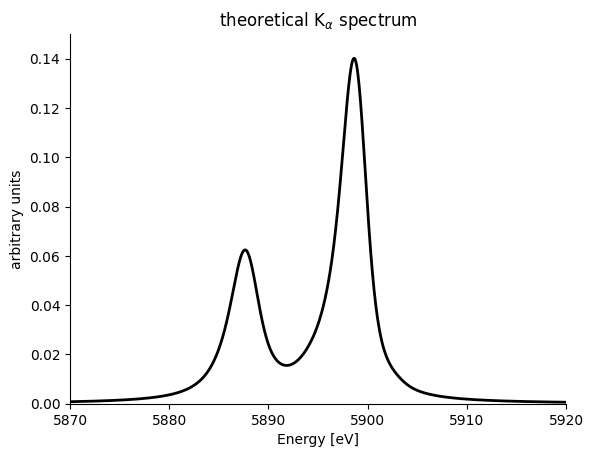

In [4]:
# plotting the theoretical model for the K_alpha line
Es = np.linspace(5870, 5920, 2000)
esc_k = 0.
plt.plot(Es, K_alpha_pdf_esc(Es, 0.7, esc_k), lw=2., color='xkcd:black')
plt.xlim(5870, 5920), plt.ylim(0, 0.15)
plt.xlabel('Energy [eV]'), plt.ylabel('arbitrary units')
plt.title(r'theoretical K$_\alpha$ spectrum')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

<div class="alert alert-info"><strong>Question:</strong></br>
Why is the K$_\alpha$ line split into two peaks?
</div>

<div class="alert alert-success"><strong>Answer:</strong></br>
The spin-orbit coupling leads to a fine structure splitting of the electron's atomic energy levels. This allows two possible energy transitions: 2p$_{1/2}$ --> 1s$_{1/2}$ and 2p$_{3/2}$ --> 1s$_{1/2}$. These result in the two K$_\alpha$ lines.
</div>

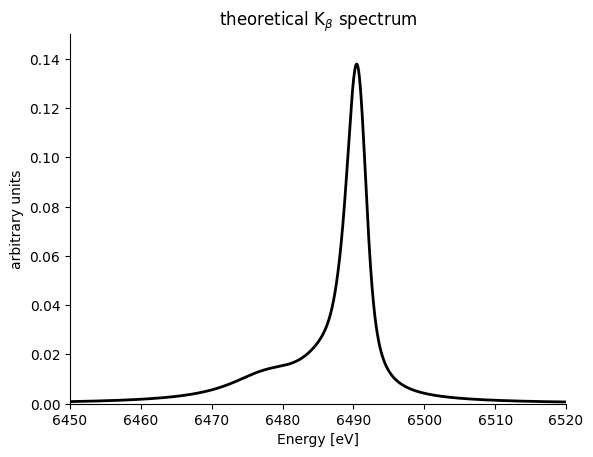

In [5]:
# plotting the theoretical model for the K_beta line
Es = np.linspace(6450, 6520, 2000)
esc_k = 0.
plt.plot(Es, K_beta_pdf_esc(Es, 0.7, esc_k), lw=2., color='xkcd:black')
plt.xlim(6450, 6520), plt.ylim(0, 0.15)
plt.xlabel('Energy [eV]'), plt.ylabel('arbitrary units')
plt.title(r'theoretical K$_\beta$ spectrum')
plt.title(r'theoretical K$_\beta$ spectrum')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

### Exercise 2: Traces

The X-rays emitted during the K$_\alpha$ and K$_\beta$ transitions in the $^{55}$Fe calibration source hit the absorber, resulting in a temperature increase $\delta T = \delta E/C_\mathrm{tot}$ in the thermally coupled paramagnetic temperature sensor. The detector is operated at mK temperatures, reducing the heat capacity $C_\mathrm{tot}$ of the system to a point, where even a small energy deposition leads to a large increase in temperature. The magnetization of the paramagnetic sensor strongly depends on its temperature, which means that an energy deposition leads to a variation of the magnetic flux. A direct current superconducting quantum interference device (dc-SQUID) is used to convert the change in the magnetic flux into a voltage change, which in turn is converted into a digital signal by an analog-to-digital converter (ADC). The resulting ADC counts are stored in the form of so-called traces. These traces have a total length of 32768 data points, taken over a duration of about 8.4 ms, with the triggering time at around 1 ms.

<div class="alert alert-info"><strong>Question:</strong></br>
What do you expect the traces to typically look like?
</div>

<div class="alert alert-success"><strong>Answer:</strong></br>
The traces consist of a baseline before the triggering time, followed by peak at the time the X-ray is absorbed. After the peak, the temperature in the detector slowly returns back to an equilibrium, resulting in a slow exponential decay after the peak.
</div>

**Task:** A subset of 100 traces is saved in `traces.csv.gz`, with each row containing the ADC count values for one trace. Plot the traces while calibrating the x-axis to show the correct time.

In [11]:
import gzip
import shutil
input_path = 'traces.csv.gz'
output_path = 'traces.csv'
with gzip.open(input_path, 'rb') as f_in:
    with open(output_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

output_path


'traces.csv'

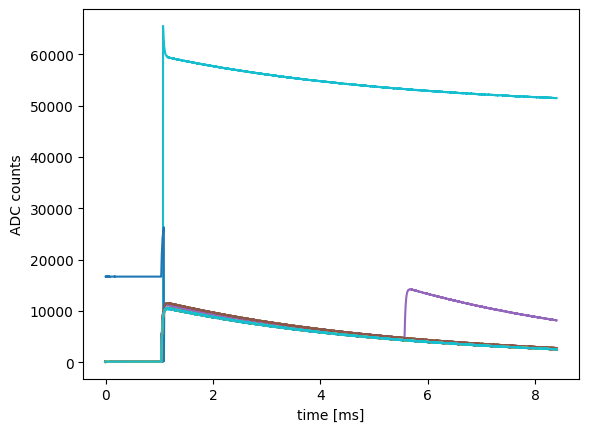

In [16]:
traces = pd.read_csv('traces.csv.gz', header=None)
#8000 traces recorded
fig, ax = plt.subplots()
for j in range(100):
    plt.plot([i/32768*8.4 for i in range(len(traces.iloc[j]))], traces.iloc[j])
plt.xlabel(r"time [ms]")
plt.ylabel("ADC counts")
plt.show()

<div class="alert alert-info"><strong>Question:</strong></br>
Which traces are caused by background processes and should not be considered for further analysis? What could cause these events?
</div>

<div class="alert alert-success"><strong>Answer:</strong></br>
Sensor events: sharp peak with rapid drop, caused by interactions directly in the paramagnetic sensor (instead of the absorber)

Pile-up events: trace on top of a trace, two interactions shortly after another, before the temperature could return to the equilibrium
</div>

### Exercise 3: Event Selection

To improve the resolution, an optimum filter (OF) is applied before the energy reconstruction. This filter minimizes a $\chi^2$ value in the frequency domain, defined as 
$$\chi^2 = \sum_\nu \frac{[S(\nu)-aA(\nu)]^2}{J(\nu)},$$
where $S(\nu)$ is the signal, $A(\nu)$ is the signal template scaled with an amplitude $a$ and $J(\nu)$ is the power spectrum density of the noise. The necessary signal templates $A(\nu)$  are obtained by averaging a set of traces and fitting a template, while the noise $J(\nu)$ is obtained by subtracting the templates from the traces. To improve the performance, two templates based on K$_\alpha$ and K$_\beta$ traces are used to perform the OF fit, resulting in the two filters OF$_\alpha$ and OF$_\beta$.

An event selection is applied to remove the bad events discussed in the previous exercise. While most of the selection cuts to quantities such as the mean and standard deviation of the baseline, the temperature and the OF amplitudes are already applied, your task is to find an appropriate cut on the baseline offset. The baseline offset is an indicator for the temperature of the detector in the moments prior to the absorption of X-rays.

**Task:** The file `rqs.csv.gz` contains different variables describing properties of the traces. 
- Plot a histogram of the `baseline_offset`.
- Find appropriate cuts to ensure a stable baseline offset without removing too many events.
- Plot the `OF_ampl_0` and `OF_ampl_1` distributions around the $K_\alpha$ and $K_\beta$ lines respectively, with and without this cut.
- Calculate the efficiency of the cut to determine how many events are discarded.

            time  channel  trace_index  temperature  mean_baseline  \
0         295986        0            1      32750.8      128.96450   
1         401300        0            2      32750.3      131.35750   
2         866004        0            3      32751.0      132.40300   
3        1039604        0            4      32749.6      128.61825   
4        1539099        0            5      32750.1      128.21525   
...          ...      ...          ...          ...            ...   
7995  2945388927        0         8649      32751.7      132.33725   
7996  2945427803        0         8650      32752.3      132.64750   
7997  2945796482        0         8651      32749.8      131.13550   
7998  2946180772        0         8652      32751.7      133.17700   
7999  2946350236        0         8653      32750.5      134.31900   

      std_baseline         mean          std            A  rise_time  ...  \
0         5.505519  4929.440704  2810.464237  10407.03550   0.000026  ...   
1    

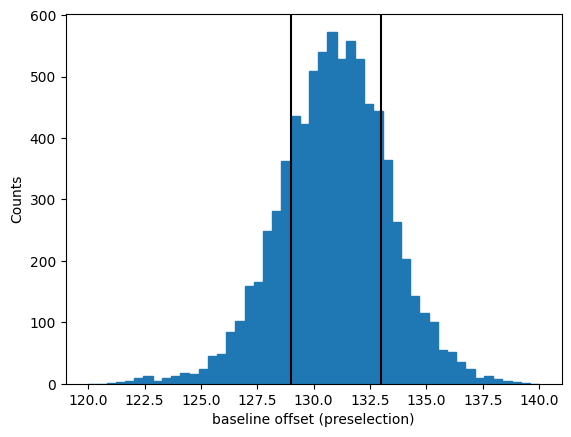

In [17]:
#load data
df = pd.read_csv('rqs.csv.gz')
print(df)
#plot baseline offset
plt.hist(df.baseline_offset, bins=np.linspace(120,140,50), lw=2., edgecolor='C0')
#plt.yscale('log')
#why these two cut selected, why 133 and 139
plt.axvline(129,color='k')
plt.axvline(133,color='k')
#plt.ylim(3,700)
plt.xlabel(r'baseline offset (preselection)')
plt.ylabel("Counts")
plt.show();

In [18]:
# set a cut on the baseline offset
mask_baseline_offset = (df['baseline_offset'] > 129) & (df['baseline_offset'] < 133)

cut efficiency:  0.6145


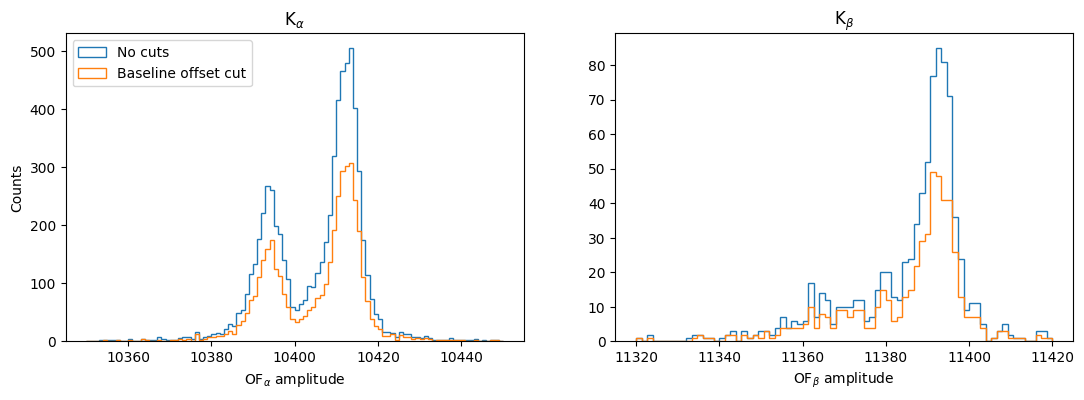

In [21]:
binning_alpha = np.linspace(1.035e4, 1.045e4, 101)
binning_beta = np.linspace(1.132e4, 1.142e4, 76)

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

plt.sca(axs[0])
plt.hist(df.OF_ampl_0, bins=binning_alpha, histtype='step', lw=2., edgecolor='C0', label='No cuts')
#plt.hist(df.OF_ampl_0, bins=binning_alpha, histtype='step', lw=2., edgecolor='C1', label='All cuts')
plt.hist(df[mask_baseline_offset].OF_ampl_0, bins=binning_alpha, histtype='step', lw=2., edgecolor='C1', label='Baseline offset cut')
plt.xlabel(r'OF$_\alpha$ amplitude'), plt.ylabel('Counts'), plt.legend(loc='upper left'), plt.title(r'K$_\alpha$')

plt.sca(axs[1])
plt.hist(df.OF_ampl_1, bins=binning_beta, histtype='step', lw=2., edgecolor='C0', label='No cuts')
#plt.hist(df.OF_ampl_1, bins=binning_beta, histtype='step', lw=2., edgecolor='C1', label='All cuts')
plt.hist(df[mask_baseline_offset].OF_ampl_1, bins=binning_beta, histtype='step', lw=2., edgecolor='C1', label='Baseline offset cut')
plt.xlabel(r'OF$_\beta$ amplitude'), plt.title(r'K$_\beta$')

print("cut efficiency: ",len(df[mask_baseline_offset].OF_ampl_0)/len(df.OF_ampl_0));


### Exercise 4: Time Correction

The following steps of the analysis should be performed both with and without the baseline offset cuts chosen in the previous exercise to inspect the impact of the cuts on the final result for the resolution. If the final fits do not converge, you should try different cut values.

In [22]:
# create a selection mask here to easily enable and disable the baseline offset cut by commenting one of the lines and rerunning the notebook
#mask_sel = np.ones_like(df['time'],dtype=bool)
mask_sel = mask_baseline_offset

Over the course of the calibration, which took around 50 minutes, the OF amplitudes steadily decreased, most likely due to a temperature drift of either the detector itself or the electronics. This effect is well described by a first-order polynomial. To account for this, a time-dependent correction is applied by fitting both OF$_\alpha$ and OF$_\beta$ to the K$_\alpha$ line and correcting for the time-dependence.

**Task:** 
- Plot the OF amplitude at the $K_\alpha$ line over the time for OF$_\alpha$ and OF$_\beta$ in the form of a two-dimensional histogram to observe the slight shift of the peaks. 
- Calculate the mean amplitudes for each time bin and parametrize the time dependence through a linear fit.
- Use this fit to calculate a corrected OF amplitude for both OF$_\alpha$ and OF$_\beta$. This is done by calculating the ratio of the original amplitude $a$ and the amplitude resulting from the Fit $a_\mathrm{fit}(t)$ and multiplying it with the mean $\mu$ of all the amplitudes used to perform the linear fit:
$$a_\mathrm{cOF} = \frac{a}{a_\mathrm{fit}(t)} \cdot \mu,$$

**Hint:** The function `stats.binned_statistic` can be useful to calculate statistics for each bin.

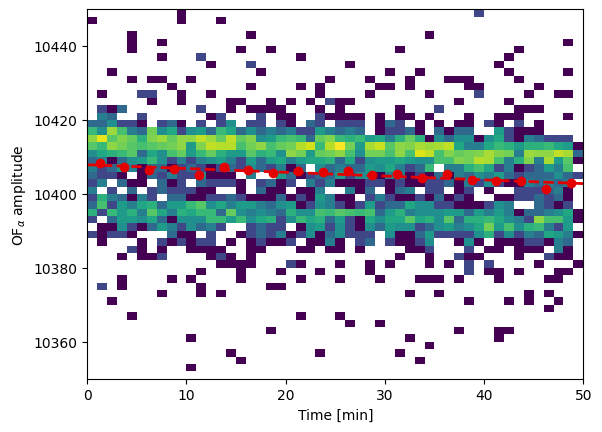

In [23]:
# 2D histogram and linear fit for OF_alpha
# this mask selects the area around the K_alpha line
order_correction = 1
mask_peak = (df.OF_ampl_0 > 1.036e4)&(df.OF_ampl_0 < 1.044e4)
mean = stats.binned_statistic(df[mask_sel&mask_peak].time, df[mask_sel&mask_peak].OF_ampl_0, 'mean',
                              bins=np.linspace(0, 3e9, 21))

mu = mean.statistic
ts = 0.5*(mean.bin_edges[1:] + mean.bin_edges[:-1])

mask_1 = mu > 1e4
mu_1 = mu[mask_1]
ts_1 = ts[mask_1]
#corr_OF_ampl = np.poly1d(np.polyfit(df[mask_peak&mask_clean].time, df[mask_peak&mask_clean].OF_ampl_0, order_correction))
#print(df.time,df.OF_ampl_0)
corr_OF_ampl = np.poly1d(np.polyfit(ts_1, mu_1, 1))

plt.hist2d(df[mask_sel].time * 1e-6 / 60, df[mask_sel].OF_ampl_0, norm=LogNorm(),
           bins=(np.linspace(0, 3e3/60, 51), np.linspace(1.035e4, 1.045e4, 51)))

plt.scatter(ts * 1e-6 / 60, mu, color='xkcd:red')
plt.plot(np.linspace(0, 3e9*1e-6/60, 100), corr_OF_ampl(np.linspace(0, 3e9, 100)), color='xkcd:red', lw=2., ls='--')
plt.xlabel('Time [min]'), plt.ylabel(r'OF$_\alpha$ amplitude');


In [11]:
# Calculate the corrected amplitude using OF_alpha
mu_mean = np.mean(mu_1)
df['cOF_ampl_0'] = df.OF_ampl_0 / corr_OF_ampl(df.time) * mu_mean


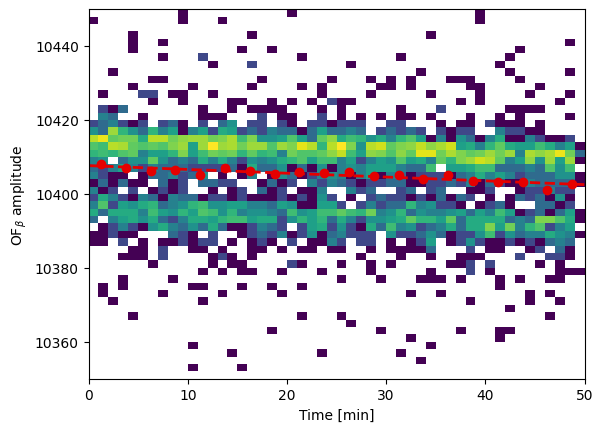

In [12]:
# 2D histogram and linear fit for OF_beta
# this mask selects the area around the K_alpha line
mask_peak = (df.OF_ampl_1 > 1.036e4)&(df.OF_ampl_1 < 1.044e4)
mean = stats.binned_statistic(df[mask_sel&mask_peak].time, df[mask_sel&mask_peak].OF_ampl_1, 'mean',
                              bins=np.linspace(0, 3e9, 21))
mu = mean.statistic
ts = 0.5*(mean.bin_edges[1:] + mean.bin_edges[:-1])

mask_1 = mu > 1e4
mu_1 = mu[mask_1]
ts_1 = ts[mask_1]
#corr_OF_ampl = np.poly1d(np.polyfit(df[mask_peak&mask_clean].time, df[mask_peak&mask_clean].OF_ampl_1, order_correction))
#print(corr_OF_ampl)
corr_OF_ampl = np.poly1d(np.polyfit(ts_1, mu_1, 1))

plt.hist2d(df[mask_sel].time * 1e-6 / 60, df[mask_sel].OF_ampl_1, norm=LogNorm(),
           bins=(np.linspace(0, 3e3/60, 51), np.linspace(1.035e4, 1.045e4, 51)))
mu = mean.statistic
ts = 0.5*(mean.bin_edges[1:] + mean.bin_edges[:-1])
plt.scatter(ts * 1e-6 / 60, mu, color='xkcd:red')
plt.plot(np.linspace(0, 3e9*1e-6/60, 100), corr_OF_ampl(np.linspace(0, 3e9, 100)), color='xkcd:red', lw=2., ls='--')
plt.xlabel('Time [min]'), plt.ylabel(r'OF$_\beta$ amplitude');

In [13]:
# Calculate the corrected amplitude using OF_beta

mu_mean = np.mean(mu_1)
df['cOF_ampl_1'] = df.OF_ampl_1 / corr_OF_ampl(df.time) * mu_mean


The two corrected amplitudes are then combined into a general corrected OF amplitude that uses the corrected OF$_\alpha$  amplitude around the K$_\alpha$ peak and the corrected OF$_\beta$ amplitude around the K$_\beta$ peak:

In [14]:
# select only areas around the K_alpha and K_beta lines for the upcoming fits
mask_fit = mask_sel & (((df.cOF_ampl_0 > binning_alpha[0])&((df.cOF_ampl_0 < binning_alpha[-1])))|((df.cOF_ampl_0 > binning_beta[0])&((df.cOF_ampl_0 < binning_beta[-1]))))
df = df[mask_fit]

# create a combined cOF, using OF_alpha around K_alpha and OF_beta around K_beta
df['cOF_ampl'] = np.zeros_like(df.cOF_ampl_0)
df.loc[((df.cOF_ampl_0 > binning_alpha[0])&((df.cOF_ampl_0 < binning_alpha[-1]))),'cOF_ampl'] = df.cOF_ampl_0[((df.cOF_ampl_0 > binning_alpha[0])&((df.cOF_ampl_0 < binning_alpha[-1])))]
df.loc[((df.cOF_ampl_0 > binning_beta[0])&((df.cOF_ampl_0 < binning_beta[-1]))), 'cOF_ampl'] = df.cOF_ampl_1[((df.cOF_ampl_0 > binning_beta[0])&((df.cOF_ampl_0 < binning_beta[-1])))]



**Task:** Plot histograms of the corrected OF amplitude around the K$_\alpha$ and K$_\beta$ peaks.

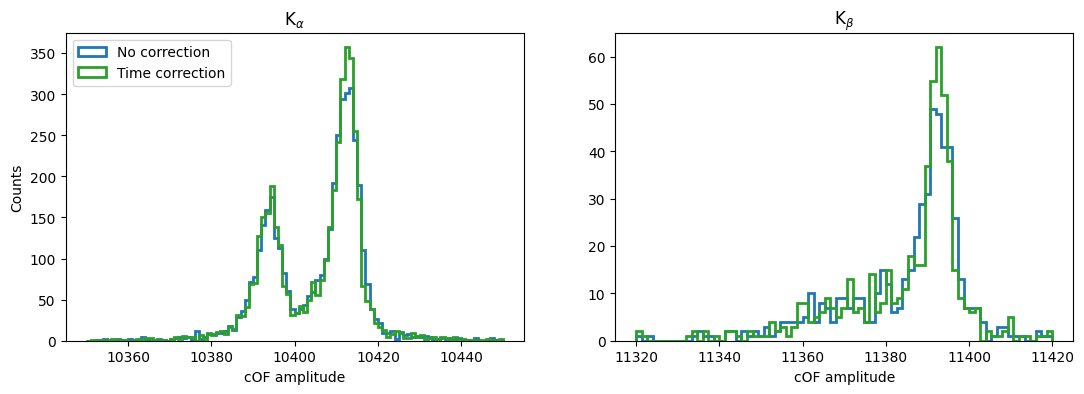

In [15]:
# Histograms of the cOF at K_alpha and K_beta
binning_alpha = np.linspace(1.035e4, 1.045e4, 101)
binning_beta = np.linspace(1.132e4, 1.142e4, 76)

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

plt.sca(axs[0])
plt.hist(df.OF_ampl_0, bins=binning_alpha, histtype='step', lw=2., edgecolor='C0', label='No correction')
plt.hist(df.cOF_ampl, bins=binning_alpha, histtype='step', lw=2., edgecolor='C2', label='Time correction')
plt.xlabel(r'cOF amplitude'), plt.ylabel('Counts'), plt.legend(loc='upper left'), plt.title(r'K$_\alpha$')

plt.sca(axs[1])
plt.hist(df.OF_ampl_1, bins=binning_beta, histtype='step', lw=2., edgecolor='C0', label='No correction')
plt.hist(df.cOF_ampl, bins=binning_beta, histtype='step', lw=2., edgecolor='C2', label='Time correction')
plt.xlabel(r'cOF amplitude'), plt.title(r'K$_\beta$');

### Exercise 5: Energy Calibration

Finally, a binned $\chi^2$ fit is performed to calibrate the OF amplitudes to energies. The spectral shape of the lines is modeled as a superposition of Voigt distributions and error functions, as discussed earlier. The calibration function correlating the corrected OF amplitude $A_\mathrm{cOF}$ to the energy is given as 
$$ E = p_1 \cdot A^2_\mathrm{cOF} + p_2 \cdot A_\mathrm{cOF}. $$


In [16]:
#calculates the chi2 value
def chi2(hist_obs, hist_model, sigma):
    return np.sum((hist_obs - hist_model)**2/sigma**2)

#the fit function used to model the K_alpha line
def model_alpha(x, mu):
    A, E_2, E_1, E_0, sigma_0, esc_k = mu
    E = E_2 * x**2 + E_1 * x + E_0
    return ka * K_alpha_pdf_esc(E, sigma_0, esc_k)

#construct the histogram from the observed data
def get_hist_obs(Es, binning):
    hist_obs, bin_edges = np.histogram(Es, bins=binning)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    return bin_centers, hist_obs

#return the fit function with the correct binning for the K_alpha line
def get_hist_model(binning, ka, sigma_0, esc_k, c):
    bin_centers = 0.5 * (binning[:-1] + binning[1:])
    return bin_centers, ka * K_alpha_pdf_esc(bin_centers, sigma_0, esc_k) + c

#return the fit function with the correct binning for the K_beta line
def get_hist_model_beta(binning, ka, sigma_0, esc_k, c):
    bin_centers = 0.5 * (binning[:-1] + binning[1:])
    return bin_centers, K_beta_pdf_esc(bin_centers, sigma_0, esc_k) + c

#perform the binned chi2 fit at the K_alpha line
def fit_model_alpha(obs, initial_values, binning, empty=False):
    
    def _minimize_function(x, ka, E_2, E_1, E_0, sigma_0, esc_k, c, binning=binning):
        Es = E_2 * x**2 + E_1 * x + E_0
        binning = np.linspace(*binning)
        E_binning = E_2 * binning**2 + E_1 * binning + E_0
        bin_centers, hist_obs = get_hist_obs(Es, E_binning)
        _, hist_model = get_hist_model(E_binning, ka, sigma_0, esc_k, c)
        return chi2(hist_obs, hist_model, np.sqrt(hist_obs))
    
    func = lambda ka, E_2, E_1, E_0, sigma_0, esc_k, c: _minimize_function(obs, ka, E_2, E_1, E_0, sigma_0, esc_k, c, binning)
    m = iminuit.Minuit(func, **initial_values)
    if not empty:
        m.fixed["ka"] = False
        m.fixed["sigma_0"] = False
        m.fixed["E_2"] = False
        m.fixed["E_1"] = False
        m.fixed["E_0"] = True
        m.fixed["esc_k"] = False
        m.fixed["c"] = True

        m.simplex().migrad()
    
    return m

In [17]:
#for K_alpha, plot the fit
#for K_beta, perform an amplitude fit while using values from the K_alpha fit for the other parameters, then plot the fit
def plot_spectrum_fit(df, model, Kline='alpha', ADC_bins=None, E_bins=None):
    
    ADC_to_E = lambda x: model.values['E_2'] * x**2 + model.values['E_1'] * x + model.values['E_0']
    if ADC_bins == None:
        binning = np.linspace(*E_bins)
    else:
        binning = ADC_to_E(np.linspace(*ADC_bins))

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    plt.subplots_adjust(hspace=0.05)

    plt.sca(ax1)
    hist, bin_edges = np.histogram(ADC_to_E(df.cOF_ampl), bins=binning)
    bin_centers = 0.5 * (binning[:-1] + binning[1:])
    plt.hist(ADC_to_E(df.cOF_ampl), bins=binning, histtype='step', label='data')
    plt.errorbar(bin_centers, hist, yerr=np.sqrt(hist), ls='None', c='C0')

    get_model = get_hist_model_beta if Kline == 'beta' else get_hist_model
    bin_centers_model, y_model = get_model(binning, model.values['ka'], model.values['sigma_0'], model.values['esc_k'], model.values['c'])
    if Kline == 'beta':
        m_beta = iminuit.Minuit(lambda a: chi2(hist, a * y_model, np.sqrt(hist)), a = 1e2)
        m_beta.simplex().migrad()
        y_model = m_beta.values['a'] * y_model
    Es = np.linspace(binning[0], binning[-1], 1001)
    bin_centers_model, y_model_plot = get_model(Es, model.values['ka'], model.values['sigma_0'], model.values['esc_k'], model.values['c'])
    y_model_plot = m_beta.values['a'] * y_model_plot if Kline == 'beta' else y_model_plot
    plt.plot(bin_centers_model, y_model_plot, label='fit')
    plt.xlim(binning[0], binning[-1]);
    plt.ylabel('Counts')
    plt.legend()

    plt.sca(ax2)
    residuals = hist - y_model
    plt.axhline(0, color='xkcd:black', lw=0.5, ls='--')
    plt.scatter(bin_centers, residuals / np.sqrt(hist), s=2.)
    plt.ylim(-5, 5)
    plt.ylabel(r'Res / $\sigma$'), plt.xlabel('Energy [eV]')
    if Kline == 'beta':
        return m_beta

In [18]:
# the initial values for the fit, determined through a lot of testing
# should not be changed
initial_values = {}
initial_values['esc_k'] = 0.015
initial_values['ka'] = 750
initial_values['E_2'] = 3.26315e-06
initial_values['E_1'] = 0.532509
initial_values['E_0'] = 0.
initial_values['sigma_0'] = 0.53
initial_values['c'] = 0.

The fit is first performed at the K$_\alpha$ line:

In [19]:
alpha_bins = (10_380, 10_422, 131)

m = fit_model_alpha(df.cOF_ampl, initial_values, alpha_bins)

In [20]:
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 196.3                      │              Nfcn = 115              │
│ EDM = 0.000191 (Goal: 0.0002)    │            time = 0.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ka      │    800    │    13     │            │            │         │         │       │
│ 1 │ E_2     │ 3.263e-6  │ 0.009e-6  │            │            │         │         │       │
│ 2 │ E_1     │ 532.51e-3 │  0.09e-3  │            │            │         │         │       │
│ 3 │ E_0     │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 4 │ sigma_0 │   0.53    │   0.06    │            │            │         │         │       │
│ 5 │ esc_k   │   0.023   │   0.010   │            │            │         │         │       │
│ 6 │ c       │    0.0    │    0.1    │            │            │         │         │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │            ka           E_2           E_1           E_0       sigma_0         esc_k             c │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┤
│      ka │           169 4.31240806e-9    -41.774e-6             0        -0.019     -11.69e-3             0 │
│     E_2 │ 4.31240806e-9      7.32e-17   -760.30e-15             0   5.57823e-12  -1.93581e-12             0 │
│     E_1 │    -41.774e-6   -760.30e-15      7.92e-09          0e-9        -28e-9        -10e-9          0e-9 │
│     E_0 │             0             0          0e-9             0         0.000             0             0 │
│ sigma_0 │        -0.019   5.57823e-12        -28e-9         0.000       0.00397       0.10e-3         0.000 │
│   esc_k │     -11.69e-3  -1.93581e-12        -10e-9             0       0.10e-3      0.000102             0 │
│       c │             0             0          0e-9             0         0.000             0             0 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────────────┘

/tmp/ipykernel_1481/3076644026.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_spectrum_fit(df[mask_fit], m, ADC_bins=alpha_bins)


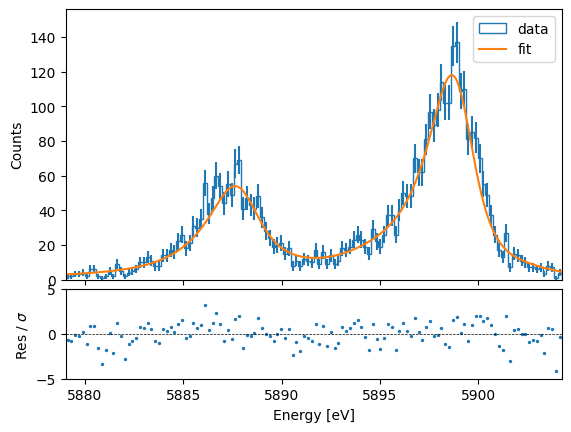

In [21]:
plot_spectrum_fit(df[mask_fit], m, ADC_bins=alpha_bins)

Another fit is performed in the area around the K$_\beta$ line, mostly using the resulting values of the K$_\alpha$ fit and only varying the amplitude. The $\chi^2$ value of this fit is used as an additional quality criterium.

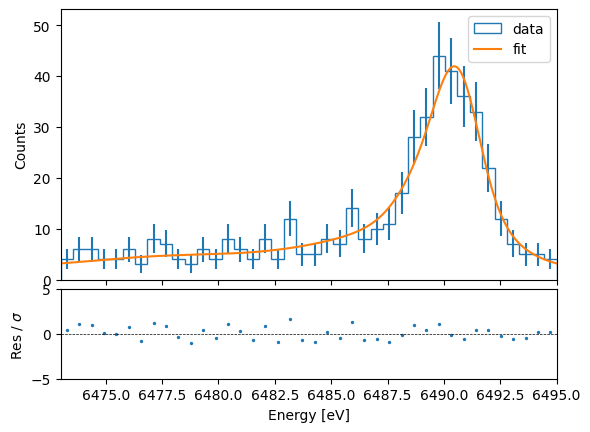

In [22]:
mb = plot_spectrum_fit(df, m, Kline='beta', E_bins=(6473, 6495, 41))

The energy resolution of the detector is defined as the full-width half-maximum (FWHM)
$$\Delta E_\mathrm{FWHM} = 2 \sqrt{2\ln 2}\  \sigma_E$$
and can be extracted from the K$_\alpha$ fit. 

**Task:** Calculate the detector resolution along with its error. The results of the fit can be accessed using `Minuit.values` and `Minuit.errors`.

In [23]:
# Your code ...
fwhm = m.values['sigma_0'] * 2 * np.sqrt(2 * np.log(2))
fwhm_err = m.errors['sigma_0'] * 2 * np.sqrt(2 * np.log(2))
print(f'FWHM: ({fwhm:.3f} +- {fwhm_err:.3f}) eV')

FWHM: (1.245 +- 0.148) eV


**Task:** Determine the reduced $\chi^2$ value ($\chi^2/$ndof) for both of these fits. Discuss the obtained values. The $\chi^2$ value can be accessed using `Minuit.fval`.

In [24]:
# Your code ...
m.fval / (alpha_bins[-1] - 1 - 5), mb.fval/(41-1-5)

(1.5702291250227027, 0.6328554382939137)